## HW1
### 주어진 ./data/minidata안의 파일 안에서 64x64 사이즈의 고양이 한마리와 128X128 사이즈의 강아지 한마리, 그리고 각각의 파일 명을 내 뱉는 Dataloader를 만드시오
### Data augmentation은 train일 경우 Horizon Flip, 랜덤90도 rotation, 랜덤 Crop을, train이 아닌 경우 하지 않도록 작성하시오

In [78]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision

from PIL import Image
import os
from glob import glob


class HwDataset(Dataset):
    def __init__(self, train_dir = '../data/minidata/train', train = False):
        self.train_dir = train_dir
        self.train_data = glob(os.path.join(self.train_dir, '*', '*'))
        self.train = train
        self.cat_transform = transforms.Compose([transforms.RandomResizedCrop((64,64)),
                                                transforms.ToTensor()
                                                ])
        self.cat_transform2 = transforms.Compose([transforms.RandomResizedCrop((64, 64)),
                                                transforms.RandomRotation((-90, 90)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                ])
        self.dog_transform = transforms.Compose([transforms.RandomResizedCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
        self.dog_transform2 = transforms.Compose([transforms.RandomResizedCrop((128, 128)),
                                                transforms.RandomRotation((-90, 90)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                ])
        
    def __len__(self):
        return len(self.train_data)
    
    #  슬라이싱을 구현할 수 있도록 돕는 메소드
    def __getitem__(self, index):
        cat = Image.open(self.train_data[index]).convert('RGB')
        tmp_dog = int(len(self.train_data)/2)
        dog = Image.open(self.train_data[index+tmp_dog]).convert('RGB')
        
        if self.train:   
            cat = self.cat_transform2(cat)
            dog = self.dog_transform2(dog)
            catname = self.train_data[index].split('\\')[-1] # Windows
            dogname = self.train_data[index+tmp_dog].split('\\')[-1] # Windows
        else: 
            cat = self.cat_transform(cat)
            dog = self.dog_transform(dog)
            catname = self.train_data[index].split('\\')[-1] # Windows
            dogname = self.train_data[index+tmp_dog].split('\\')[-1] # Windows
        return cat, dog, catname, dogname

mydataset = HwDataset()
# print('Dataset의 개수',len(mydataset))
mydataset[1]

(tensor([[[0.6627, 0.6706, 0.6941,  ..., 0.8549, 0.8431, 0.8392],
          [0.6667, 0.6745, 0.7020,  ..., 0.8549, 0.8431, 0.8353],
          [0.6745, 0.6902, 0.7137,  ..., 0.8510, 0.8471, 0.8314],
          ...,
          [0.6980, 0.7647, 0.8000,  ..., 0.5294, 0.5176, 0.5216],
          [0.6824, 0.7529, 0.8078,  ..., 0.5294, 0.5176, 0.5176],
          [0.6941, 0.7686, 0.8157,  ..., 0.5294, 0.5216, 0.5176]],
 
         [[0.6314, 0.6392, 0.6627,  ..., 0.8549, 0.8431, 0.8353],
          [0.6588, 0.6667, 0.6863,  ..., 0.8510, 0.8353, 0.8314],
          [0.6784, 0.6941, 0.7137,  ..., 0.8431, 0.8314, 0.8275],
          ...,
          [0.7176, 0.7843, 0.8196,  ..., 0.4627, 0.4510, 0.4549],
          [0.7020, 0.7725, 0.8275,  ..., 0.4627, 0.4549, 0.4549],
          [0.7137, 0.7882, 0.8353,  ..., 0.4627, 0.4549, 0.4549]],
 
         [[0.6000, 0.6078, 0.6314,  ..., 0.8431, 0.8275, 0.8196],
          [0.6392, 0.6471, 0.6667,  ..., 0.8353, 0.8196, 0.8118],
          [0.6549, 0.6706, 0.6941,  ...,

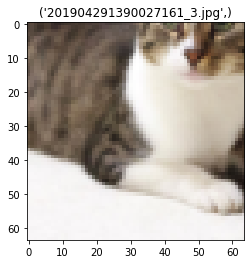

<function matplotlib.pyplot.close(fig=None)>

In [80]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow

# 데이터를 확인해 봅시다 !
cat, dog, catname, dogname = next(iter(torch.utils.data.DataLoader(mydataset, batch_size=1, shuffle=False)))
im = plt.imshow(cat[0].permute(1,2,0))
plt.title(catname)
plt.show()
plt.close

In [88]:
train_dataset = HwDataset('../data/minidata/train',train=True)
val_dataset = HwDataset('../data/minidata/val',train=False)

## HW2
### 2_NeuralNetwork.ipynb의 Let's Do It 코드를 작성해서 결과를 확인하시오

In [100]:
# 필요한 train test코드를 다 작성하세요
import torch 
import torch.nn as nn #
import torch.nn.functional as F # 각종 activation 함수
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [101]:
def MNIST_DATA(root='../data/minidata', ntrain=True, ntransforms=None, 
               ndownload =True, batch_size = 32, num_worker = 1):
    
    print ("[+] Get the MNIST DATA")
    
    mnist_train = vision_dsets.MNIST(root = root,  
                                    train = True, 
                                    transform = T.ToTensor(), 
                                    download = True)  
    
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False,  
                                    transform = T.ToTensor(),
                                    download = True)

    trainDataLoader = data.DataLoader(dataset = mnist_train, 
                                      batch_size = batch_size,  
                                      shuffle =True, 
                                      num_workers = 1) 

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size, 
                                    shuffle = False, 
                                    num_workers = 1) 
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [106]:
trainDset, testDset, trainDataLoader, testDataLoader = MNIST_DATA(batch_size = 32)  # Data Loader 를 불러 옵니다. 

[+] Get the MNIST DATA


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/minidata\MNIST\raw\train-images-idx3-ubyte.gz to ../data/minidata\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/minidata\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/minidata\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/minidata\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/minidata\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/minidata\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/minidata\MNIST\raw

[+] Finished loading data & Preprocessing


In [107]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data 
                inputs = inputs.to('cpu')
                labels = labels.to('cpu')
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs) 
                loss = self.criterion(outputs, labels) 
                loss.backward() 
                self.optimizer.step() 

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        with torch.no_grad():
            self.net.eval() 
            test_loss = 0
            correct = 0
            for inputs, labels in self.testloader:
                inputs = inputs.to('cpu')
                labels = labels.to('cpu')
                output = self.net(inputs) 
                pred = output.max(1, keepdim=True)[1] 
                correct += pred.eq(labels.view_as(pred)).sum().item() 

                test_loss /= len(self.testloader.dataset)
            print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                    format(correct, len(self.testloader.dataset),
                    100.* correct / len(self.testloader.dataset)))

In [108]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1, 
                              out_channels = 8,
                              kernel_size = 6,
                              stride = 2) # Layer 1
        self.conv0_bn = nn.GroupNorm(num_groups = 4, num_channels = 8)
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) # Layer 2

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [109]:
mnist_net = MNIST_Net().to('cpu')  
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [110]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [111]:
trainer.train(epoch = 5)

[1,   500] loss: 0.511
[1,  1000] loss: 0.191
[1,  1500] loss: 0.151
[2,   500] loss: 0.113
[2,  1000] loss: 0.096
[2,  1500] loss: 0.091
[3,   500] loss: 0.080
[3,  1000] loss: 0.076
[3,  1500] loss: 0.071
[4,   500] loss: 0.070
[4,  1000] loss: 0.067
[4,  1500] loss: 0.071
[5,   500] loss: 0.058
[5,  1000] loss: 0.055
[5,  1500] loss: 0.068
Finished Training


In [112]:
trainer.test()


Test set:  Accuracy: 9798/10000 (98%)



## (Optional) HW3
### 3_VGG.ipynb를 참조해 VGG16을 구현하세요